In [77]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

In [78]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.describe()

,objID,z,uMAG,rMAG,u-r,SVMPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,-18.495233,-20.575399,2.080166,0.558053
std,6.022167e+12,0.023058,1.034802,1.140994,0.610873,0.496619
min,1.237646e+18,0.003001,-26.045010,-25.957740,-3.803460,0.000000
25%,1.237658e+18,0.045979,-19.147785,-21.304710,1.660000,0.000000
50%,1.237662e+18,0.067202,-18.601710,-20.713750,2.158930,1.000000
75%,1.237665e+18,0.082217,-18.002450,-20.047520,2.500980,1.000000
max,1.237680e+18,0.100000,54.116670,-13.083160,78.125900,1.000000


In [79]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50) & (df['rMAG']>-22)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=10000)

Dataframe size post-cut: 413856


In [80]:
max(df['uMAG'])

-8.49766

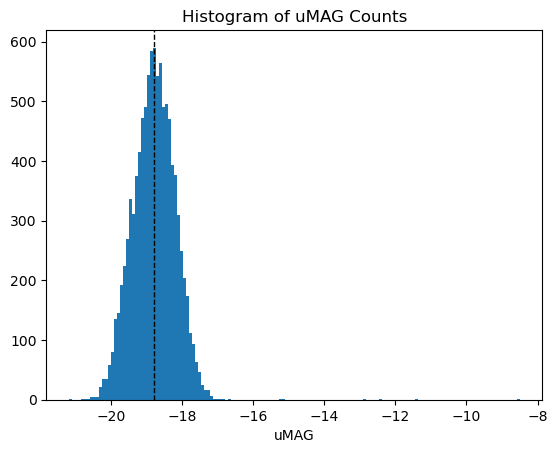

-19.548192999999998 -18.040276


In [81]:
plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

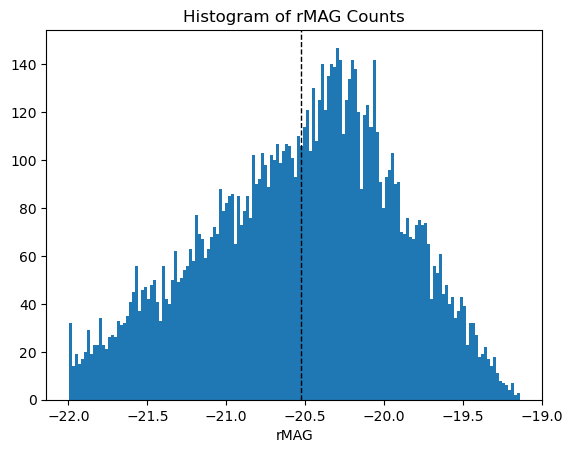

In [82]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

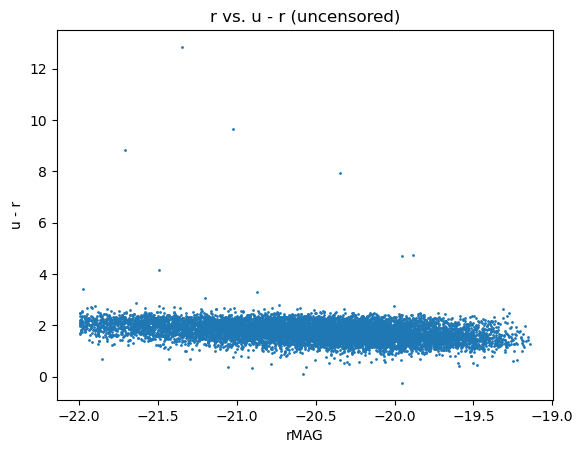

In [83]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (uncensored)")
plt.show()

In [84]:
# Adding censored data column for -19.5 < uMAG < -18.1
print(len(df[df["uMAG"]>-18]))
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.5) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.5):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

868


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored
134479,1237658422487810252,0.066242,-18.93568,-20.96901,2.03333,1,-18.93568,0.0
177454,1237658491749597377,0.055452,-18.12999,-19.84428,1.71430,1,-18.12999,0.0
271073,1237662662142722267,0.069592,-18.66147,-20.21381,1.55235,1,-18.66147,0.0
244395,1237665352394932381,0.055487,-18.30146,-20.33228,2.03082,1,-18.30146,0.0
102010,1237648722834292851,0.063959,-19.31363,-20.59803,1.28439,1,-19.31363,0.0


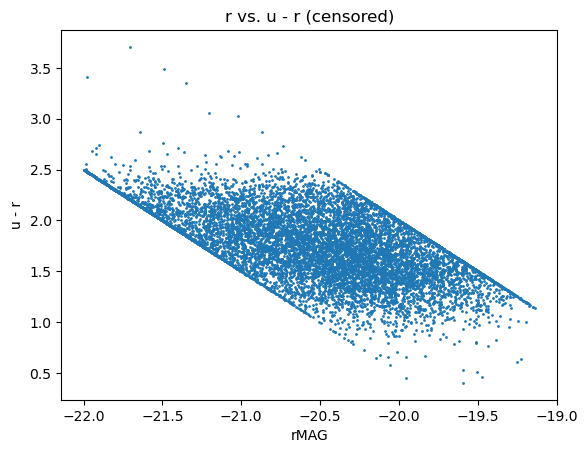

In [85]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (censored)")
plt.show()

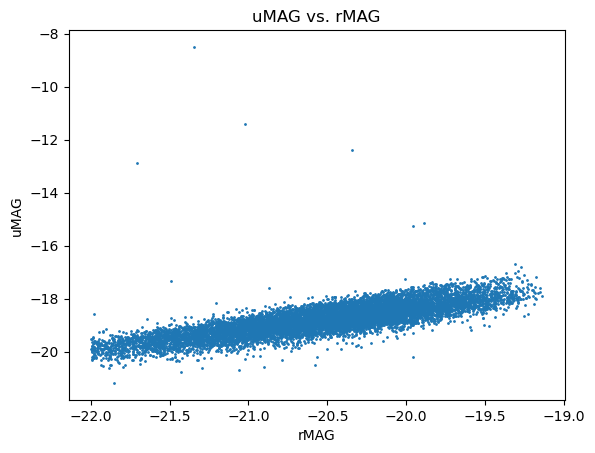

In [86]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')
plt.show()

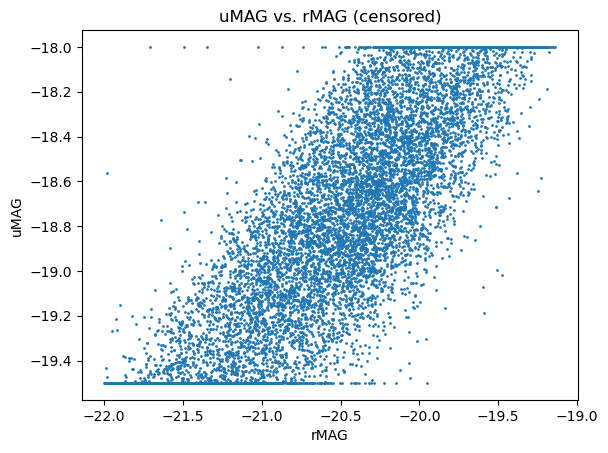

In [87]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

# `r vs u - r (uncensored)`

In [12]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model

In [18]:
q1_model = lregression(df['rMAG'], df['u-r'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 114 seconds.


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

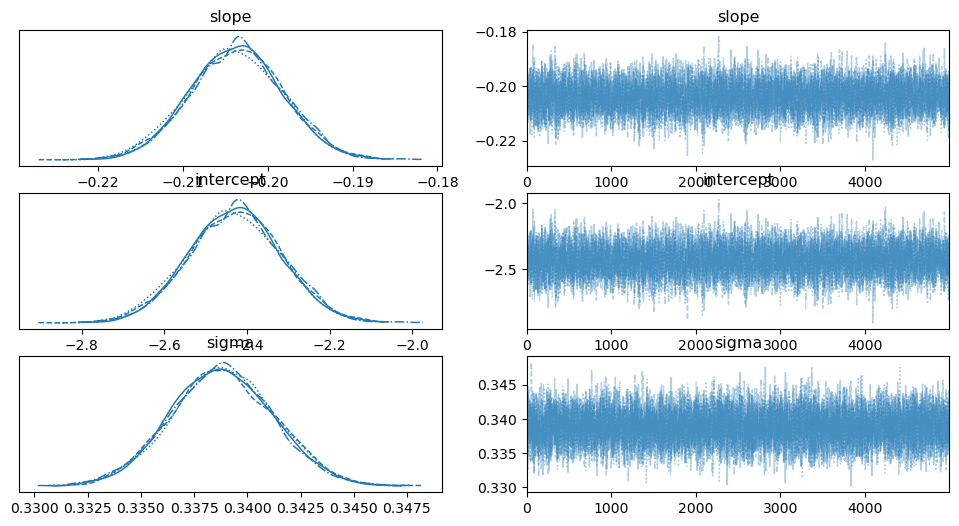

In [19]:
az.plot_trace(q1_fit)

In [54]:
slope3=np.percentile(np.array(q1_fit["posterior"]["slope"])[0],3)
slope97=np.percentile(np.array(q1_fit["posterior"]["slope"])[0],97)
intercept3=np.percentile(np.array(q1_fit["posterior"]["intercept"])[0],3)
intercept97=np.percentile(np.array(q1_fit["posterior"]["intercept"])[0],97)
print(slope3,slope97,intercept3,intercept97)

-0.21346777708744416 -0.19338883894741693 -2.629887738854173 -2.219079259565907


In [20]:
summ=az.summary(q1_fit)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.204,0.006,-0.214,-0.193,0.000,0.000,5758.0,6374.0,1.0
intercept,-2.430,0.113,-2.641,-2.218,0.001,0.001,5753.0,6475.0,1.0
sigma,0.339,0.002,0.334,0.343,0.000,0.000,8403.0,8432.0,1.0


In [93]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="red", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")

[Text(0.5, 1.0, 'u-r vs r (uncensored data) fit')]

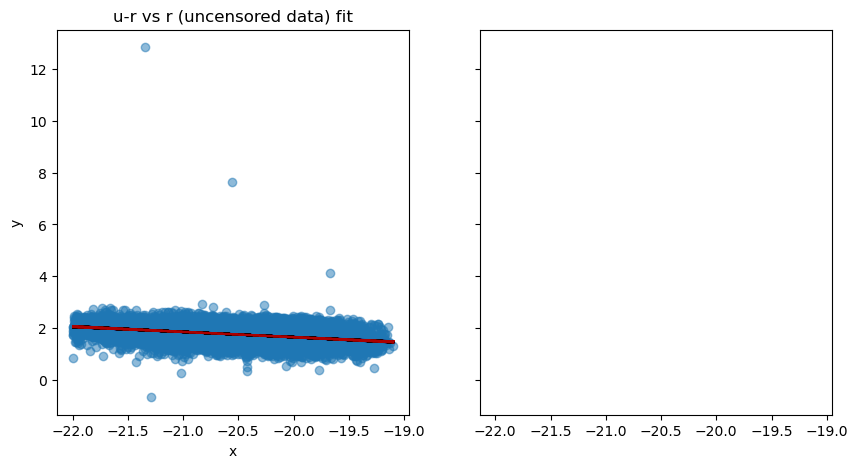

In [60]:


x=np.linspace(-22,-19,50)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="u-r vs r (uncensored data) fit")

# `u-r vs r (censored)`

In [62]:
df['uMAG'].describe()

count    10000.000000
mean       -18.777881
std          0.591844
min        -21.969500
25%        -19.177467
50%        -18.761850
75%        -18.371233
max         -8.497660
Name: uMAG, dtype: float64

In [88]:
def censored_regression(x, y):
    with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1 + x, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)

        start = pm.find_MAP()
        step = pm.NUTS()
    return model

In [89]:
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(5000, init="adapt_diag", step=pm.NUTS())

C:\Users\wally\AppData\Local\Temp\ipykernel_13464\1578033120.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
C:\Users\wally\AppData\Local\Temp\ipykernel_13464\1578033120.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1758 seconds.


In [90]:
summ_censored=az.summary(censored_fit)
summ_censored

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.202,0.006,-0.213,-0.190,0.000,0.000,5536.0,6244.0,1.0
intercept,-2.401,0.125,-2.634,-2.163,0.002,0.001,5537.0,6311.0,1.0
sigma,0.319,0.003,0.314,0.324,0.000,0.000,8011.0,7882.0,1.0


[Text(0.5, 1.0, 'r vs u (censored) fit')]

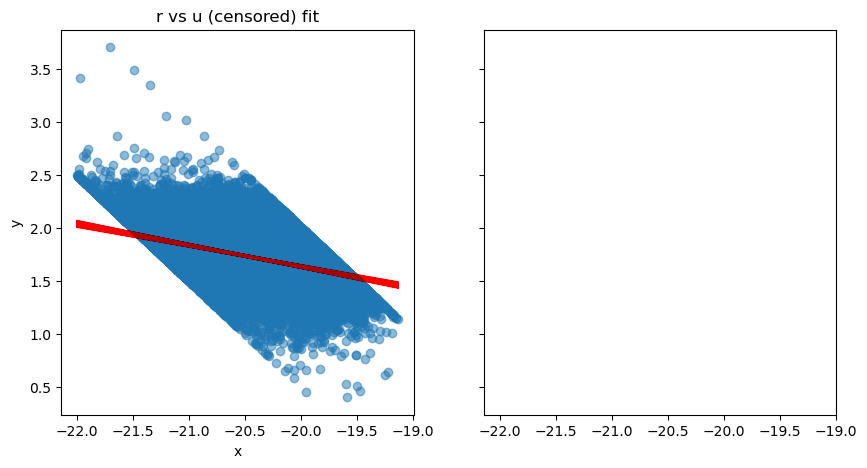

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u (censored) fit")

These are the older charts from when it was just u vs r for reference.

In [69]:
summ_censored=az.summary(censored_fit)
summ_censored

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.797,0.006,0.785,0.807,0.000,0.000,6232.0,7195.0,1.0
intercept,-2.428,0.120,-2.661,-2.214,0.002,0.001,6219.0,7130.0,1.0
sigma,0.310,0.002,0.306,0.315,0.000,0.000,7075.0,7113.0,1.0


[Text(0.5, 1.0, 'r vs u (censored) fit')]

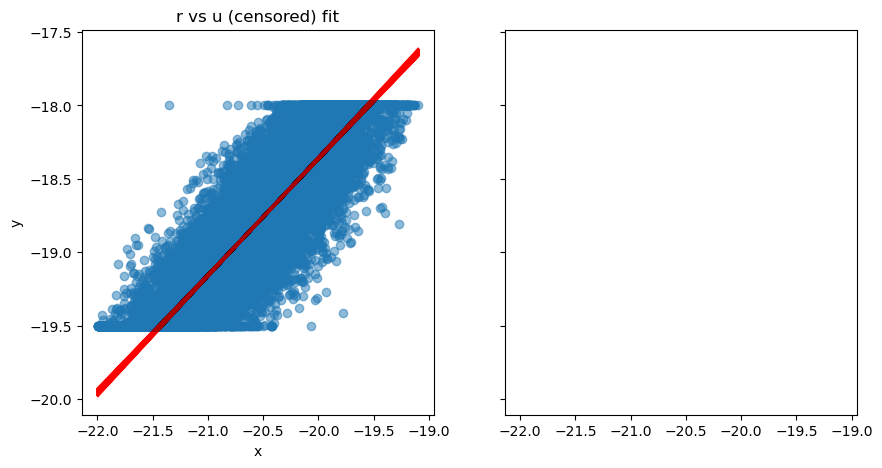

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['censored_uMAG'],alpha=0.5)
pp_plot(df['rMAG'], df['censored_uMAG'], censored_fit, ax[0],true=True)
ax[0].set(title="r vs u (censored) fit")